
## CS316 project
**AI-Based Recyclable Waste Classification**

By:

Norah Bin Salamah 
Deem Alhaqbani 
Lina Bin Muammar 


# Task
Refactor the existing PyTorch image classification pipeline to support training and comparing multiple ResNet models. This involves creating functions for data preparation and model training/evaluation, then instantiating and training four separate ResNet models with potentially varied hyperparameters. Finally, generate comparative plots of validation accuracy and loss over epochs for all trained models, and summarize their performance differences and insights.

##  Data Preparation


 a function to encapsulate the data loading, transformation, splitting, and DataLoader creation steps. This function will return the train, validation, and test DataLoaders, along with the device and garbage classes, to be reused for training multiple models.


In [ ]:
def prepare_data(directory, batch_size, random_seed):
    # Get the list of garbage classes
    garbage_classes = os.listdir(directory)

    # Define image transformations
    transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

    # Load the dataset and apply transformations
    dataset = ImageFolder(directory, transform = transformations)

    # Set random seed for reproducibility
    torch.manual_seed(random_seed)

    # Split the dataset into train, validation, and test sets
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    # Determine the device (CPU or GPU)
    device = get_default_device()

    # Create DataLoaders
    train_dataloader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
    validation_dataloader = DataLoader(val_data, batch_size * 2, num_workers = 4, pin_memory = True)
    test_dataloader = DataLoader(test_data, batch_size, num_workers = 2, pin_memory = True) # Assuming 2 workers for test as well

    # Wrap DataLoaders to move data to device
    train_dataloader = DataLoad(train_dataloader, device)
    validation_dataloader = DataLoad(validation_dataloader, device)
    test_dataloader = DataLoad(test_dataloader, device)

    return train_dataloader, validation_dataloader, test_dataloader, device, garbage_classes

print("Function 'prepare_data' defined successfully.")

Function 'prepare_data' defined successfully.


## Model Training and Evaluation


 a function that takes a model, training parameters (epochs, learning rate, optimizer), and DataLoaders as input, and performs the training and evaluation loop. This function should return the training history (losses and accuracies) for each model.


In [ ]:
import torch

@torch.no_grad()
def evaluate(model, validator):
    model.eval() # Evaluation Mode
    outputs = [model.validating(batch) for batch in validator]
    return model.validating_epoch_final(outputs)

def train_model(epochs, learning_rate, model, train_loader, validator, opt_func=torch.optim.SGD):
    training_history = [] # List to store the training history
    optimizer = opt_func(model.parameters(), learning_rate)
    for epoch in range(epochs): # Loop for each epoch

        # Training Step

        model.train() # Training Mode
        train_loss = [] # List to store the training loss
        for batch in train_loader: # Loop for each batch
            loss = model.training_step(batch) # Calculate the loss
            train_loss.append(loss) # Append the loss to the list
            loss.backward() # Backpropagate the loss
            optimizer.step() # Update the parameters using the optimizer
            optimizer.zero_grad() # Reset the gradients to zero for the next batch

        # Validation phase
        result = evaluate(model, validator) # Evaluate the model on the validation set
        result['Train Loss'] = torch.stack(train_loss).mean().item() # Calculate the average training loss
        model.epoch_final(epoch, result) # Call the epoch_final method on the model
        training_history.append(result) # Append the results to the training history
    return training_history

print("Functions 'evaluate' and 'train_model' defined successfully.")

Functions 'evaluate' and 'train_model' defined successfully.


## Train Multiple Models


Instantiate and train four separate instances of the `ResNet` model using the refactored training function. Ensure each model's training history is stored for later comparison.



First, prepare the data by calling the `prepare_data` function, which will return the necessary data loaders, device, and garbage classes for all subsequent model training. Then,instantiate and train four separate `ResNet` models, each with potentially varied hyperparameters, and store their training histories.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
import os


# --- Helper functions and classes definitions (re-included for scope) ---
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device2 = get_default_device()

def move_to_gpu(data, device):
    # Move Tensor to GPU
    if isinstance(data, (list, tuple)):
        return [move_to_gpu(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DataLoad():
    def __init__(self, data, device):
        self.data = data
        self.device = get_default_device()

    def __iter__(self):
        for batch in self.data:
            yield move_to_gpu(batch, self.device)

    def __len__(self):
        return len(self.data)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validating(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'Validation Loss': loss.detach(), 'Validation Accuracy': acc}

    def validating_epoch_final(self, outputs):
        batch_loss = [x['Validation Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_accuracy = [x['Validation Accuracy'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'Validation Loss': epoch_loss.item(), 'Validation Accuracy': epoch_accuracy.item()}

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Training Loss'], result['Validation Loss'], result['Validation Accuracy']))

class ResNet(ImageClassification):
    def __init__(self):
        super().__init__()
        # Using ResNet50 pretrained model
        self.network = models.resnet50(weights = "ResNet50_Weights.DEFAULT")
        features = self.network.fc.in_features
        self.network.fc = nn.Linear(features, len(garbage_classes)) # Replacing last layer with a linear layer of garbage classes with length 6

    def forward(self, image):
        return torch.sigmoid(self.network(image))  # Using sigmoid activation function

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Train Loss'], result['Validation Loss'], result['Validation Accuracy']))
# --- End of helper definitions ---

# Call the prepare_data function
directory_original = "/content/drive/MyDrive/CS316_project/dataset"
batch_size = 32
random_seed = 43

garbage_classes = os.listdir(directory_original)

train_dataloader, validation_dataloader, test_dataloader, device, garbage_classes = prepare_data(
    directory_original, batch_size, random_seed
)

print(f"original Data prepared successfully. Device: {device}, Number of classes: {len(garbage_classes)}")

## Call the prepare_data function on the new dataset
directory_new = "/content/drive/MyDrive/CS316_project/New_Dataset"
batch_size = 32
random_seed = 43

garbage_classes = os.listdir(directory_new)

train_dataloader2, validation_dataloader2, test_dataloader2, device2, garbage_classes2 = prepare_data(
    directory_new, batch_size, random_seed
)

print(f"New Data prepared successfully. Device: {device2}, Number of classes: {len(garbage_classes2)}")


# Store training histories for all models
all_models_history = {}

# 2. Train four separate ResNet models

# Model 1: original Model
model_name_1 = "Model_original_LR_0.00001_Epochs_50"
model_1 = ResNet()
model_1 = move_to_gpu(model_1, device)
epochs_1 = 50
learning_rate_1 = 0.00001
optimizer_1 = torch.optim.Adam
print(f"\n--- Training {model_name_1} ---")
history_1 = train_model(epochs_1, learning_rate_1, model_1, train_dataloader, validation_dataloader, optimizer_1)
all_models_history[model_name_1] = history_1

# Model 2: Higher learning rate
model_name_2 = "Model_2_Higher_LR_0.0001_Epochs_50"
model_2 = ResNet()
model_2 = move_to_gpu(model_2, device)
epochs_2 = 50
learning_rate_2 = 0.0001 # Higher learning rate
optimizer_2 = torch.optim.Adam
print(f"\n--- Training {model_name_2} ---")
history_2 = train_model(epochs_2, learning_rate_2, model_2, train_dataloader, validation_dataloader, optimizer_2)
all_models_history[model_name_2] = history_2

# Model 3: More epochs
model_name_3 = "Model_3_Less_Epochs_10_LR_0.00001"
model_3 = ResNet()
model_3 = move_to_gpu(model_3, device)
epochs_3 = 10 # Less epochs
learning_rate_3 = 0.00001
optimizer_3 = torch.optim.Adam
print(f"\n--- Training {model_name_3} ---")
history_3 = train_model(epochs_3, learning_rate_3, model_3, train_dataloader, validation_dataloader, optimizer_3)
all_models_history[model_name_3] = history_3

# Model 4: New Dataset
model_name_4 = "Model_4_New_Dataset_LR_0.00001_Epochs_50"
model_4 = ResNet()
model_4 = move_to_gpu(model_4, device2)
epochs_4 = 50
learning_rate_4 = 0.00001
optimizer_4 = torch.optim.Adam
print(f"\n--- Training {model_name_4} ---")
history_4 = train_model(epochs_4, learning_rate_4, model_4, train_dataloader2, validation_dataloader2, optimizer_4)
all_models_history[model_name_4] = history_4

print("\nAll models trained and histories stored.")
print(f"Stored histories for models: {list(all_models_history.keys())}")


original Data prepared successfully. Device: cuda, Number of classes: 6
New Data prepared successfully. Device: cuda, Number of classes: 6
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]



--- Training Model_original_LR_0.00001_Epochs_50 ---
Epoch [1], Training Loss: 1.7739, Validation Loss: 1.7554, Validation Accuracy: 0.4302
Epoch [2], Training Loss: 1.7276, Validation Loss: 1.7073, Validation Accuracy: 0.5902
Epoch [3], Training Loss: 1.6666, Validation Loss: 1.6436, Validation Accuracy: 0.6712
Epoch [4], Training Loss: 1.5905, Validation Loss: 1.5729, Validation Accuracy: 0.7171
Epoch [5], Training Loss: 1.5153, Validation Loss: 1.5010, Validation Accuracy: 0.7503
Epoch [6], Training Loss: 1.4469, Validation Loss: 1.4438, Validation Accuracy: 0.7779
Epoch [7], Training Loss: 1.3867, Validation Loss: 1.4010, Validation Accuracy: 0.8014
Epoch [8], Training Loss: 1.3475, Validation Loss: 1.3645, Validation Accuracy: 0.8152
Epoch [9], Training Loss: 1.3056, Validation Loss: 1.3309, Validation Accuracy: 0.8289
Epoch [10], Training Loss: 1.2707, Validation Loss: 1.3015, Validation Accuracy: 0.8447
Epoch [11], Training Loss: 1.2358, Validation Loss: 1.2765, Validation Accu

## Plot Comparative Accuracy

single plot displaying the validation accuracy over epochs for all four trained models.


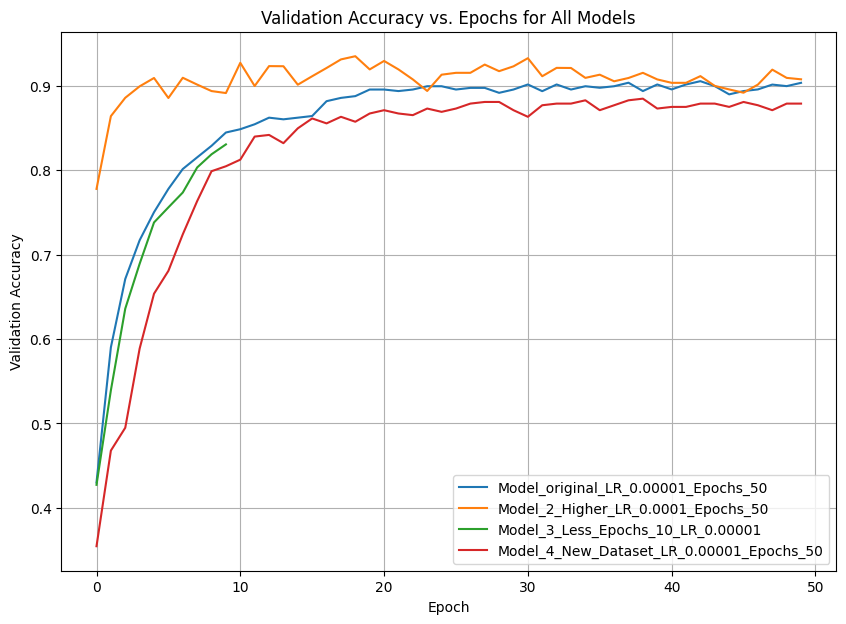

Comparative accuracy plot generated.


In [ ]:
import matplotlib.pyplot as plt

def plot_comparative_accuracy(all_models_history):
    plt.figure(figsize=(10, 7))
    for model_name, history in all_models_history.items():
        accuracies = [x['Validation Accuracy'] for x in history]
        plt.plot(accuracies, label=model_name)

    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Epochs for All Models')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparative_accuracy(all_models_history)
print("Comparative accuracy plot generated.")

## Plot Comparative Loss

 a single plot displaying the validation loss over epochs for all four trained models.


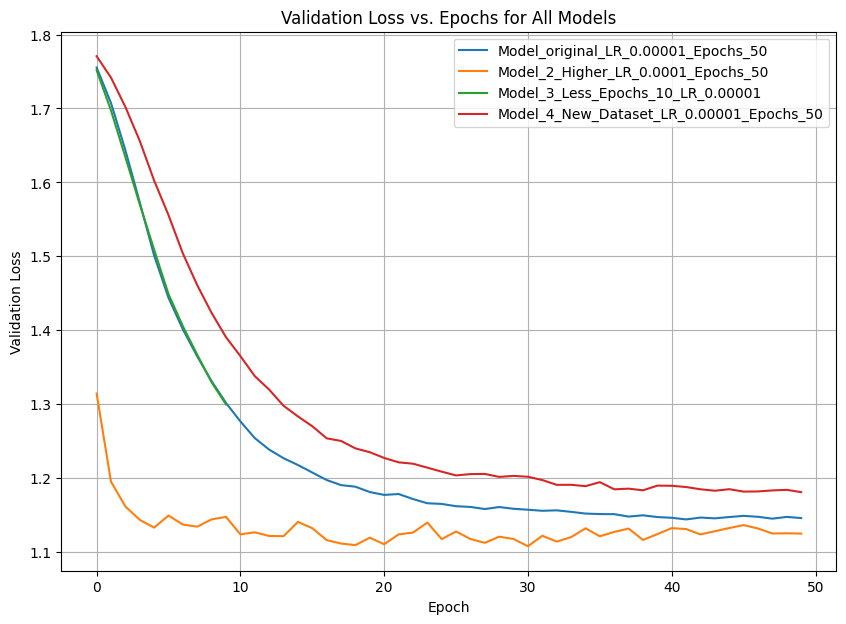

Comparative loss plot generated.


In [ ]:
import matplotlib.pyplot as plt

def plot_comparative_loss(all_models_history):
    plt.figure(figsize=(10, 7))
    for model_name, history in all_models_history.items():
        validation_losses = [x['Validation Loss'] for x in history]
        plt.plot(validation_losses, label=model_name)

    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs. Epochs for All Models')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming all_models_history is populated from previous steps
plot_comparative_loss(all_models_history)
print("Comparative loss plot generated.")

## Display Final Accuracy Scores


Extract and print the final validation accuracy score (as a percentage, e.g., out of 100%) for each of the trained models to compare their performance.


In [ ]:
print("\n--- Final Validation Accuracy for Each Model ---")
for model_name, history in all_models_history.items():
    if history:
        final_epoch_result = history[-1] # Get the last epoch's result
        final_accuracy = final_epoch_result.get('Validation Accuracy', 0.0) # Get validation accuracy, default to 0 if not found
        print(f"{model_name}: {final_accuracy * 100:.2f}%")
    else:
        print(f"{model_name}: No training history available.")



--- Final Validation Accuracy for Each Model ---
Model_original_LR_0.00001_Epochs_50: 90.35%
Model_2_Higher_LR_0.0001_Epochs_50: 90.77%
Model_3_Less_Epochs_10_LR_0.00001: 83.06%
Model_4_New_Dataset_LR_0.00001_Epochs_50: 87.89%


## Plot Final Accuracy Comparison



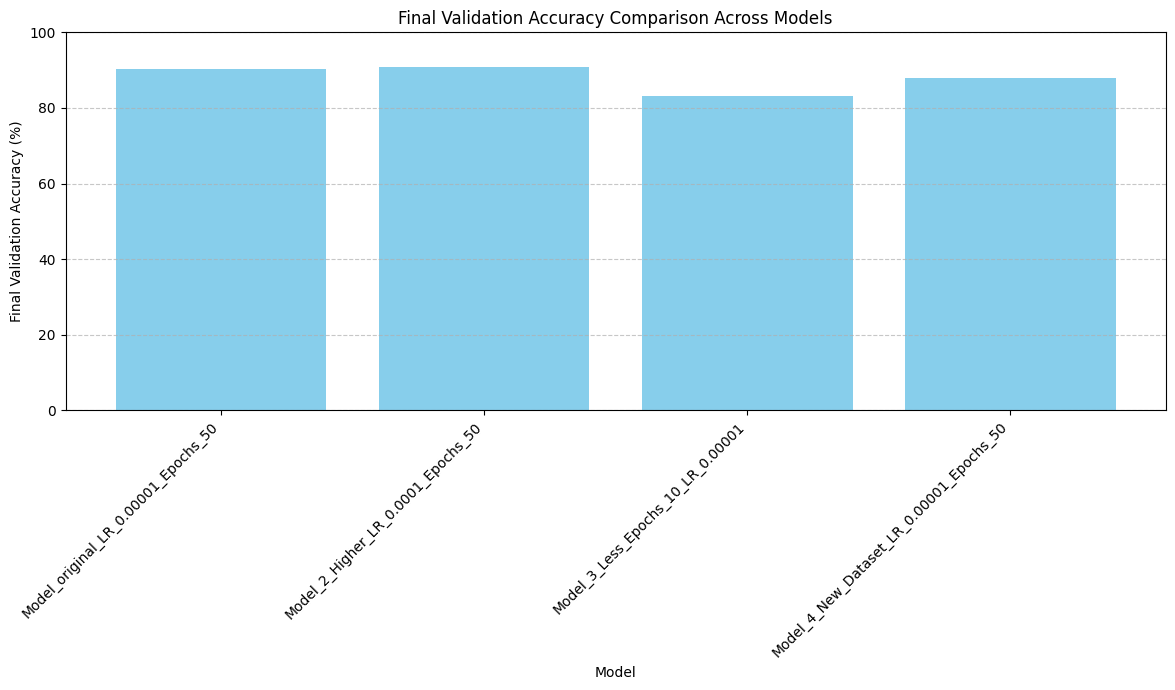

Bar chart for final validation accuracy comparison generated.


In [ ]:
import matplotlib.pyplot as plt

model_names = []
final_accuracies = []

for model_name, history in all_models_history.items():
    if history:
        final_epoch_result = history[-1]
        final_accuracy = final_epoch_result.get('Validation Accuracy', 0.0)
        model_names.append(model_name)
        final_accuracies.append(final_accuracy * 100)

plt.figure(figsize=(12, 7))
plt.bar(model_names, final_accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Final Validation Accuracy (%)')
plt.title('Final Validation Accuracy Comparison Across Models')
plt.ylim(0, 100) # Ensure y-axis is from 0 to 100%
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Bar chart for final validation accuracy comparison generated.")

## Evaluate Models with Detailed Metrics and Visualize Confusion Matrices

For each trained model, evaluate its performance on the test dataset to calculate detailed classification metrics such as Precision, Recall, and F1-score for each class. Also, generate the Confusion Matrix for each model with heatmap visualizations of the Confusion Matrix for each model on the test dataset.


--- Evaluation for Model_1_Base_LR_0.00001_Epochs_10 ---

Classification Report:
              precision    recall  f1-score   support

       metal       0.97      0.87      0.92        95
       glass       0.95      0.93      0.94        92
   cardboard       0.90      0.90      0.90        83
       trash       0.90      0.94      0.92       111
     plastic       0.87      0.93      0.90       101
       paper       0.70      0.68      0.69        28

    accuracy                           0.90       510
   macro avg       0.88      0.88      0.88       510
weighted avg       0.91      0.90      0.90       510


Confusion Matrix:
[[ 83   1   1   9   1   0]
 [  0  86   2   0   4   0]
 [  0   2  75   0   4   2]
 [  3   0   1 104   0   3]
 [  0   2   1   1  94   3]
 [  0   0   3   1   5  19]]

--- Evaluation for Model_2_Higher_LR_0.0001_Epochs_50 ---

Classification Report:
              precision    recall  f1-score   support

       metal       1.00      0.89      0.94        95
 

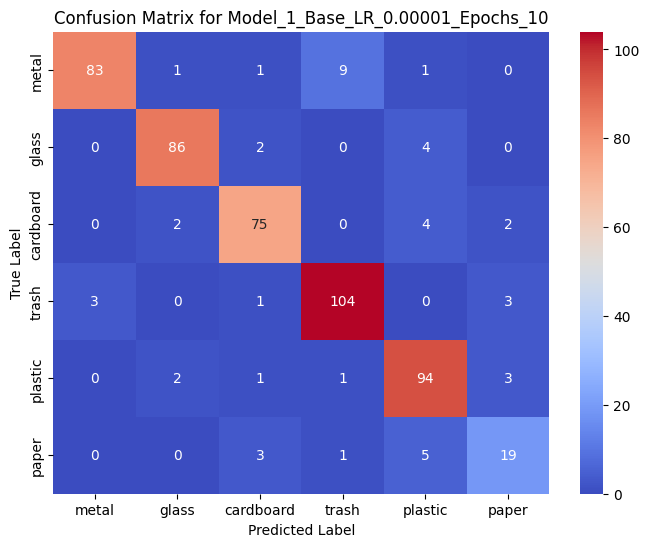

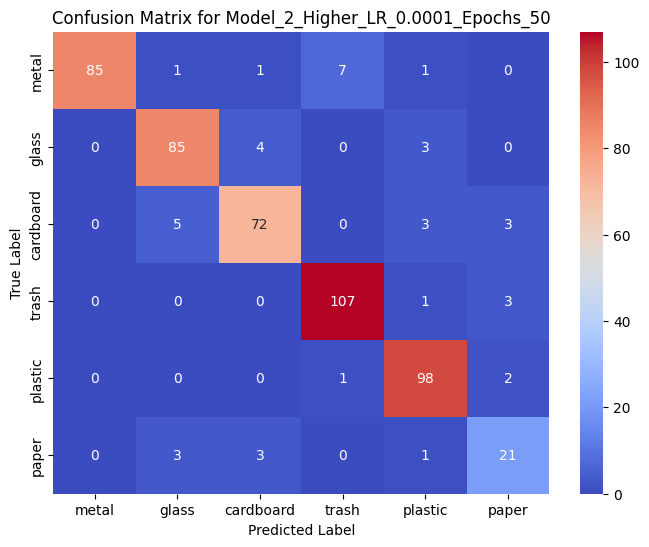

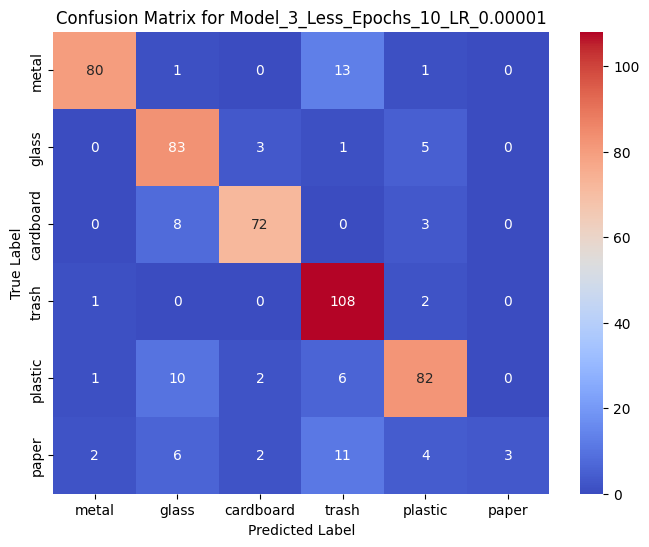

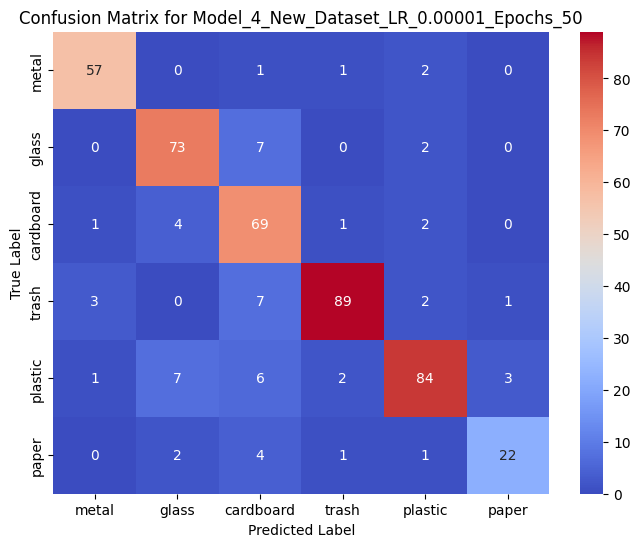

Confusion matrix heatmaps generated for all models.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_report(model, test_loader, class_names, device):
    model.eval()  # Set model to evaluation mode
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in test_loader:
            # Move data to the appropriate device
            images = move_to_gpu(images, device)
            labels = move_to_gpu(labels, device)

            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs.data, 1) # Get predicted class labels

            # Move labels back to CPU and convert to NumPy arrays
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    # Generate classification report
    report = classification_report(all_true_labels, all_predicted_labels, target_names=class_names, output_dict=True, zero_division=0)
    print("\nClassification Report:")
    print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names, zero_division=0))

    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    print("\nConfusion Matrix:")
    print(cm)

    return report, cm

# Store reports and confusion matrices for all models
model_eval_results = {}

print("\n--- Evaluation for Model_1_Base_LR_0.00001_Epochs_10 ---")
report_1, cm_1 = evaluate_and_report(model_1, test_dataloader, garbage_classes, device)
model_eval_results["Model_1_Base_LR_0.00001_Epochs_10"] = {'report': report_1, 'cm': cm_1}

print("\n--- Evaluation for Model_2_Higher_LR_0.0001_Epochs_50 ---")
report_2, cm_2 = evaluate_and_report(model_2, test_dataloader, garbage_classes, device)
model_eval_results["Model_2_Higher_LR_0.0001_Epochs_50"] = {'report': report_2, 'cm': cm_2}

print("\n--- Evaluation for Model_3_Less_Epochs_10_LR_0.00001 ---")
report_3, cm_3 = evaluate_and_report(model_3, test_dataloader, garbage_classes, device)
model_eval_results["Model_3_Less_Epochs_10_LR_0.00001"] = {'report': report_3, 'cm': cm_3}

print("\n--- Evaluation for Model_4_New_Dataset_LR_0.00001_Epochs_50 ---")
report_4, cm_4 = evaluate_and_report(model_4, test_dataloader2, garbage_classes2, device2)
model_eval_results["Model_4_New_Dataset_LR_0.00001_Epochs_50"] = {'report': report_4, 'cm': cm_4}

print("Classification reports and confusion matrices collected for all models.")

# Plot Confusion Matrices
for model_name, results in model_eval_results.items():
    cm = results['cm']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=garbage_classes, yticklabels=garbage_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

print("Confusion matrix heatmaps generated for all models.")

## Plot Per-Class F1-Score Comparison

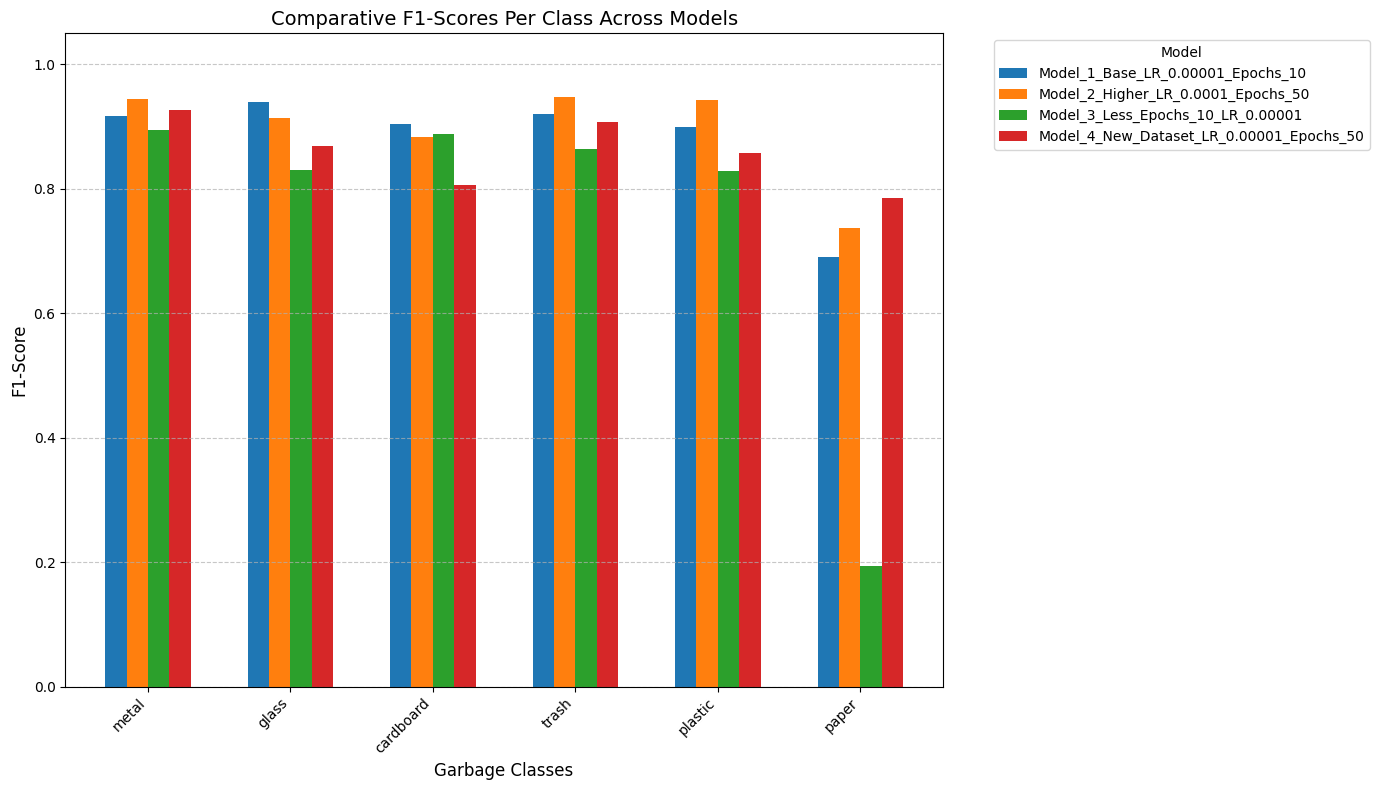

Bar chart for comparative F1-scores per class generated.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract F1-scores for each class from all models
class_f1_scores = {}
for model_name, results in model_eval_results.items():
    report = results['report']
    f1_scores = {class_name: report[class_name]['f1-score'] for class_name in garbage_classes}
    class_f1_scores[model_name] = f1_scores

# Convert to DataFrame for easier plotting
f1_df = pd.DataFrame(class_f1_scores)

# Plotting the F1-scores
fig, ax = plt.subplots(figsize=(14, 8))

num_models = len(f1_df.columns)
num_classes = len(f1_df.index)
bar_width = 0.15

# Create an array for the x-axis positions for each group of bars (classes)
index = np.arange(num_classes)

# Plot bars for each model
for i, model_name in enumerate(f1_df.columns):
    ax.bar(index + i * bar_width, f1_df[model_name], bar_width, label=model_name)

ax.set_xlabel('Garbage Classes', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Comparative F1-Scores Per Class Across Models', fontsize=14)
ax.set_xticks(index + bar_width * (num_models - 1) / 2)
ax.set_xticklabels(f1_df.index, rotation=45, ha='right', fontsize=10)
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.05) # F1-score ranges from 0 to 1
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Bar chart for comparative F1-scores per class generated.")

## Plot Per-Class Precision Comparison



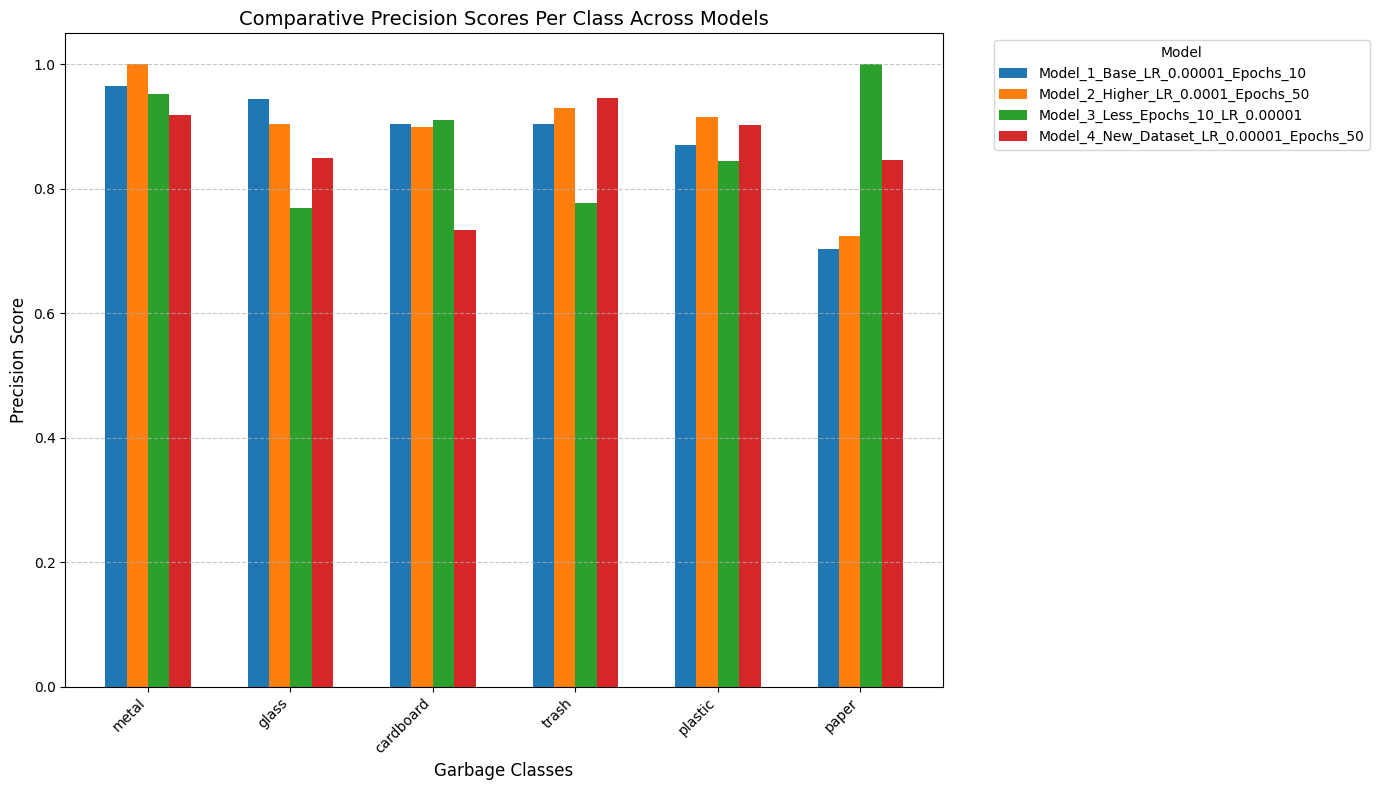

Bar chart for comparative Precision scores per class generated.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract Precision scores for each class from all models
class_precision_scores = {}
for model_name, results in model_eval_results.items():
    report = results['report']
    precision_scores = {class_name: report[class_name]['precision'] for class_name in garbage_classes}
    class_precision_scores[model_name] = precision_scores

# Convert to DataFrame for easier plotting
precision_df = pd.DataFrame(class_precision_scores)

# Plotting the Precision scores
fig, ax = plt.subplots(figsize=(14, 8))

num_models = len(precision_df.columns)
num_classes = len(precision_df.index)
bar_width = 0.15

# Create an array for the x-axis positions for each group of bars (classes)
index = np.arange(num_classes)

# Plot bars for each model
for i, model_name in enumerate(precision_df.columns):
    ax.bar(index + i * bar_width, precision_df[model_name], bar_width, label=model_name)

ax.set_xlabel('Garbage Classes', fontsize=12)
ax.set_ylabel('Precision Score', fontsize=12)
ax.set_title('Comparative Precision Scores Per Class Across Models', fontsize=14)
ax.set_xticks(index + bar_width * (num_models - 1) / 2)
ax.set_xticklabels(precision_df.index, rotation=45, ha='right', fontsize=10)
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.05) # Precision score ranges from 0 to 1
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Bar chart for comparative Precision scores per class generated.")

## Plot Per-Class Recall Comparison



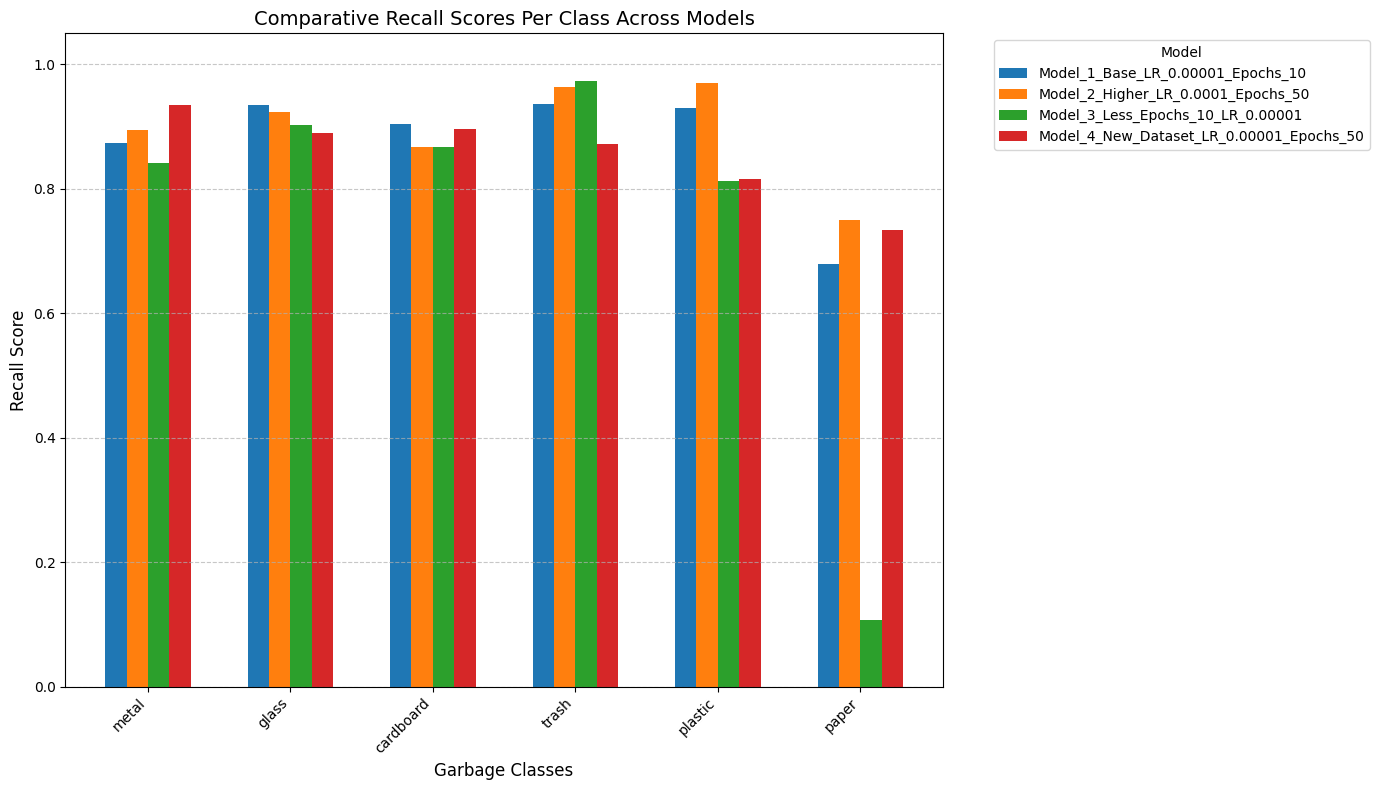

Bar chart for comparative Recall scores per class generated.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract Recall scores for each class from all models
class_recall_scores = {}
for model_name, results in model_eval_results.items():
    report = results['report']
    recall_scores = {class_name: report[class_name]['recall'] for class_name in garbage_classes}
    class_recall_scores[model_name] = recall_scores

# Convert to DataFrame for easier plotting
recall_df = pd.DataFrame(class_recall_scores)

# Plotting the Recall scores
fig, ax = plt.subplots(figsize=(14, 8))

num_models = len(recall_df.columns)
num_classes = len(recall_df.index)
bar_width = 0.15

# Create an array for the x-axis positions for each group of bars (classes)
index = np.arange(num_classes)

# Plot bars for each model
for i, model_name in enumerate(recall_df.columns):
    ax.bar(index + i * bar_width, recall_df[model_name], bar_width, label=model_name)

ax.set_xlabel('Garbage Classes', fontsize=12)
ax.set_ylabel('Recall Score', fontsize=12)
ax.set_title('Comparative Recall Scores Per Class Across Models', fontsize=14)
ax.set_xticks(index + bar_width * (num_models - 1) / 2)
ax.set_xticklabels(recall_df.index, rotation=45, ha='right', fontsize=10)
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.05) # Recall score ranges from 0 to 1
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Bar chart for comparative Recall scores per class generated.")


## Plot Combined Validation Trends



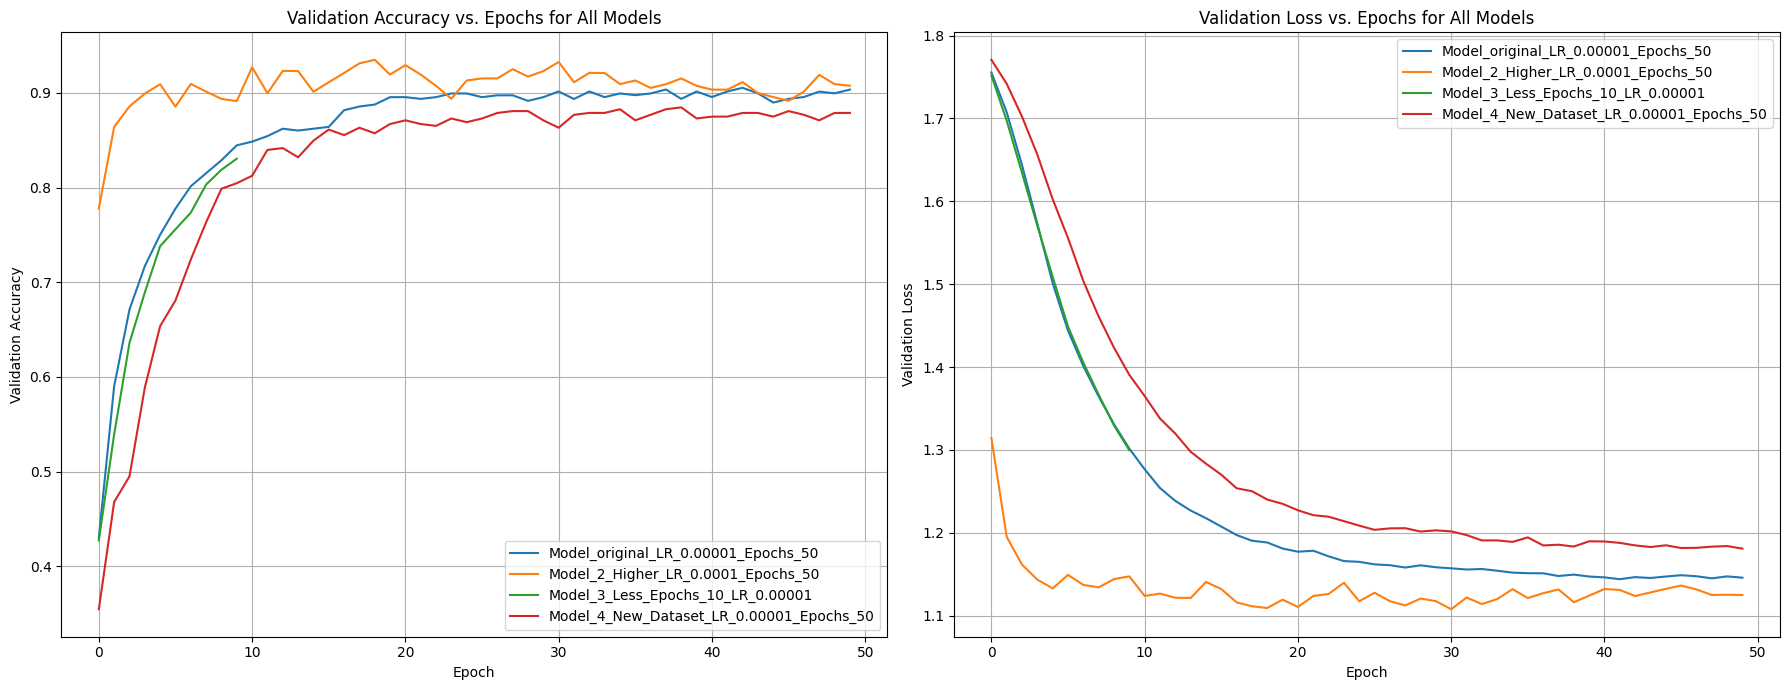

Combined validation accuracy and loss plots generated.


In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot Validation Accuracy
ax1 = axes[0]
for model_name, history in all_models_history.items():
    accuracies = [x['Validation Accuracy'] for x in history]
    ax1.plot(accuracies, label=model_name)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Validation Accuracy vs. Epochs for All Models')
ax1.legend()
ax1.grid(True)

# Plot Validation Loss
ax2 = axes[1]
for model_name, history in all_models_history.items():
    validation_losses = [x['Validation Loss'] for x in history]
    ax2.plot(validation_losses, label=model_name)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss vs. Epochs for All Models')
ax2.legend()
ax2.grid(True)

# Ensure proper spacing between subplots
plt.tight_layout()

# Display the combined plot
plt.show()

print("Combined validation accuracy and loss plots generated.")

## Plot Per-Class Performance Across Models

### Subtask:
Generate a figure with subplots (e.g., a 2x3 grid, one for each garbage class). Each subplot will show a grouped bar chart comparing the Precision, Recall, and F1-score for that specific class across all four trained models. This offers a highly detailed, class-specific comparison of model performance.


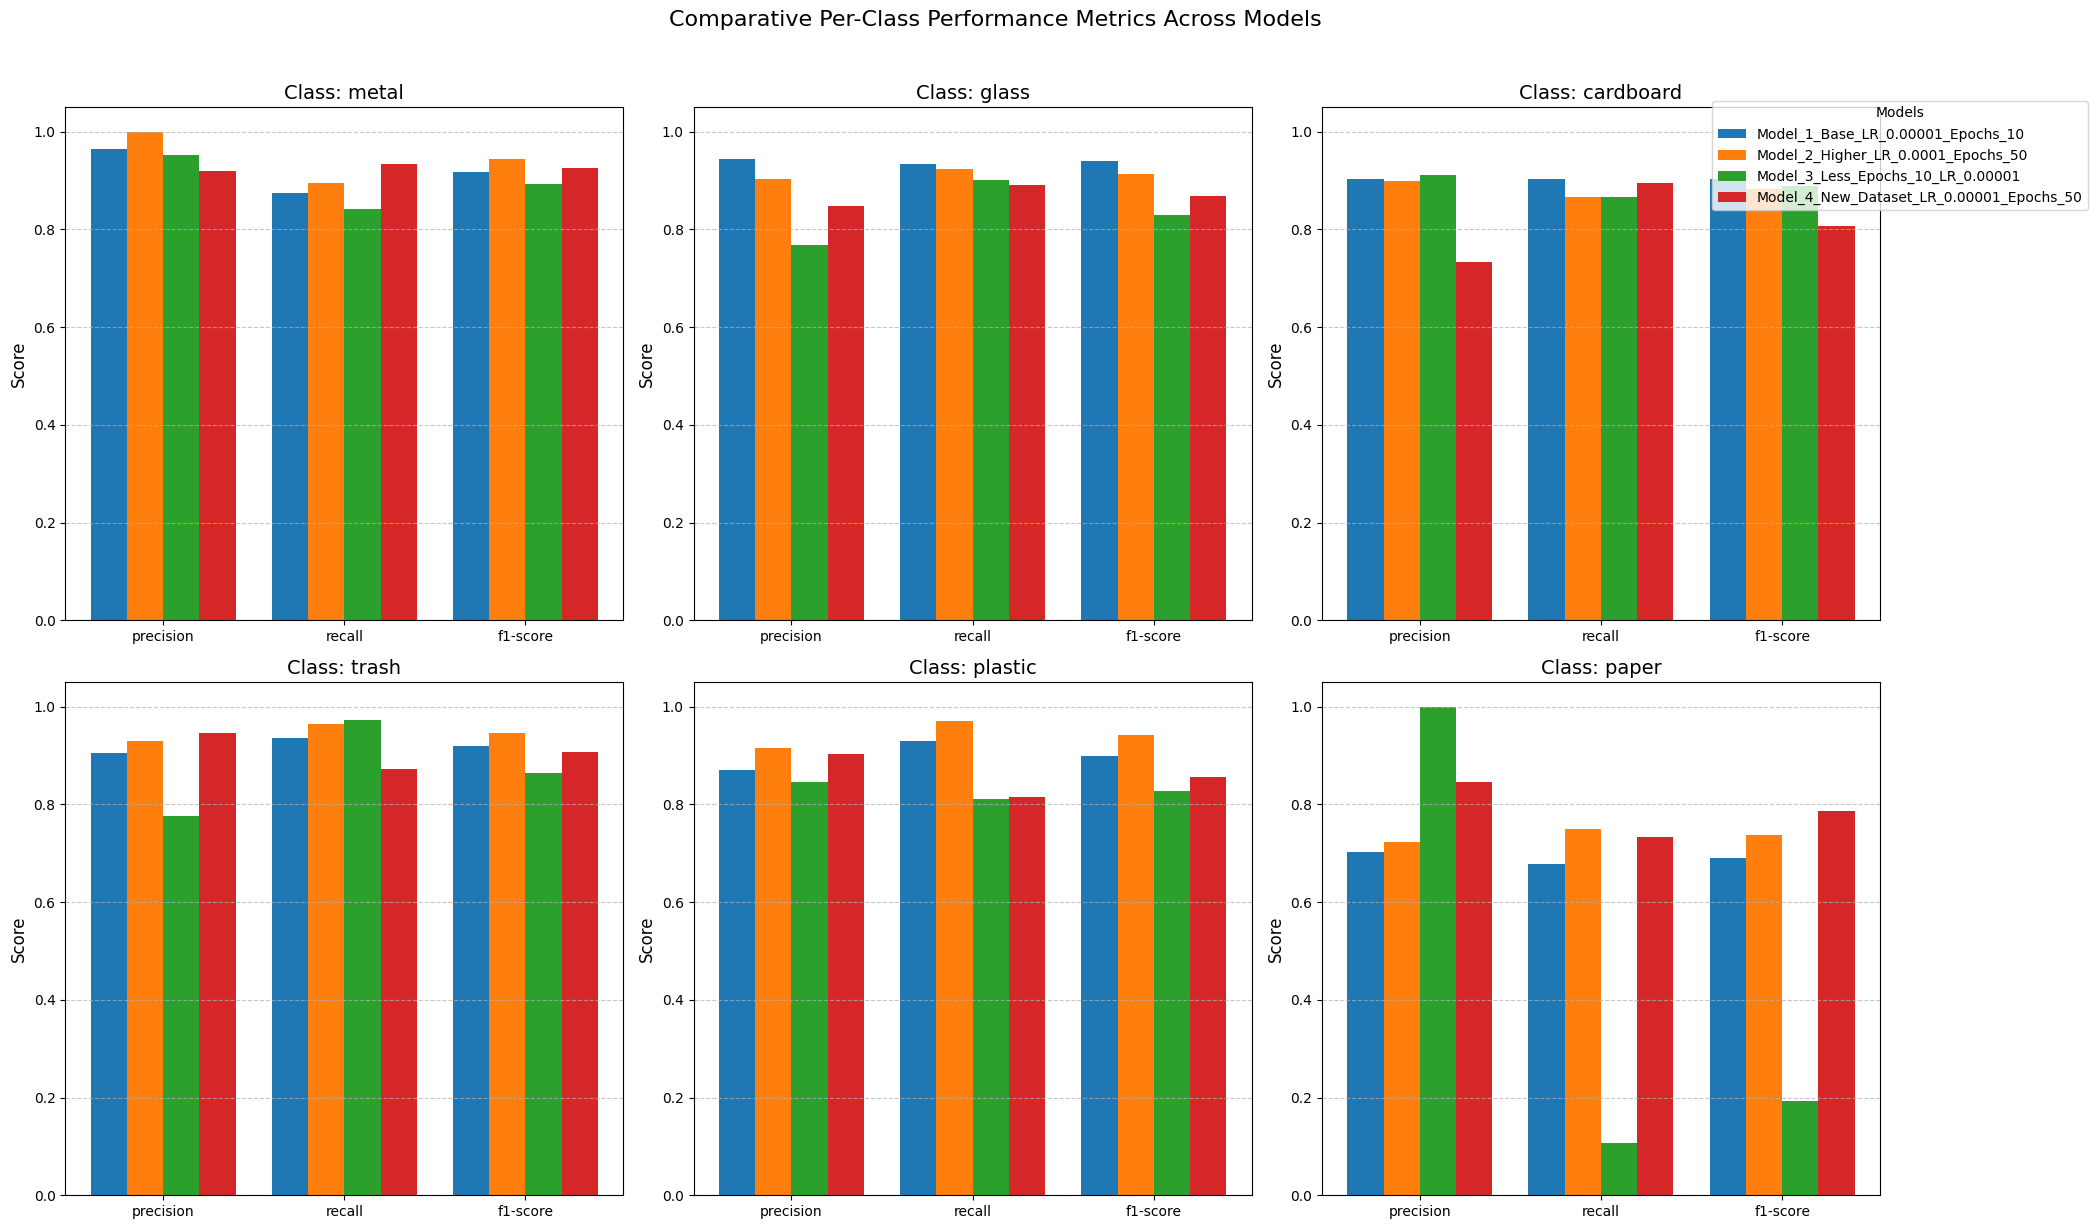

Combined per-class performance comparison plot generated.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the list of garbage classes from the current context
# Assuming garbage_classes is already defined and contains the class names

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten() # Flatten the 2x3 array of axes for easier iteration

bar_width = 0.2
metrics = ['precision', 'recall', 'f1-score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Distinct colors for models

for i, class_name in enumerate(garbage_classes):
    ax = axes[i]

    # Collect data for the current class across all models
    model_scores = {} # Stores {model_name: {metric: score}}
    for model_name, results in model_eval_results.items():
        report = results['report']
        if class_name in report:
            model_scores[model_name] = {
                'precision': report[class_name]['precision'],
                'recall': report[class_name]['recall'],
                'f1-score': report[class_name]['f1-score']
            }
        else: # Handle cases where a class might not be in a report (e.g., if zero_division=0 was used and no instances)
             model_scores[model_name] = {
                'precision': 0.0,
                'recall': 0.0,
                'f1-score': 0.0
            }

    # Prepare bar positions
    x = np.arange(len(metrics)) # positions for each metric (P, R, F1)
    num_models = len(model_eval_results)
    offset_step = bar_width * (num_models / 2) # Center the groups

    for j, (model_name, scores) in enumerate(model_scores.items()):
        # Create bars for precision, recall, f1-score for the current model
        bars_data = [scores['precision'], scores['recall'], scores['f1-score']]
        ax.bar(x + (j - num_models / 2 + 0.5) * bar_width, bars_data, bar_width, label=model_name, color=colors[j])

    ax.set_title(f'Class: {class_name}', fontsize=14)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=0, fontsize=10)
    ax.set_ylim(0, 1.05) # Scores are between 0 and 1
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 0.95), title='Models')

fig.suptitle('Comparative Per-Class Performance Metrics Across Models', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for the legend
plt.show()

print("Combined per-class performance comparison plot generated.")

# Task
Calculate ROC and AUC for each trained model (`Model_1_Base_LR_0.00001_Epochs_10`, `Model_2_Higher_LR_0.00005_Epochs_10`, `Model_3_More_Epochs_20_LR_0.00001`, and `Model_4_SGD_Optimizer_LR_0.00001_Epochs_10`) using their respective test datasets. This will involve obtaining predicted probability scores for each class (one-vs-rest approach) and then using `sklearn.metrics.roc_curve` and `sklearn.metrics.auc` to compute the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the Curve (AUC). Subsequently, generate two sets of comparative plots: one showing the ROC curves for `Model_1`, `Model_2`, and `Model_3` across their shared classes, and another for `Model_4` across its classes. Each plot will display the ROC curve for each model per class, clearly labeled with the model name and its corresponding AUC score, along with appropriate axis labels and a title. Finally, summarize the ROC and AUC comparison, identifying the best-performing model based on average AUC across classes.

## Calculate ROC and AUC

### Subtask:
For each trained model, predict probabilities on the test dataset. Then, calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the Curve (AUC) using `sklearn.metrics.roc_curve` and `sklearn.metrics.auc`. Store these values for plotting.


**Reasoning**:
The subtask requires calculating ROC and AUC for each model and class. I will write a code block to import necessary libraries, define a dictionary to store ROC data, iterate through each model configuration, perform predictions on the test set, one-hot encode the labels, and then calculate FPR, TPR, and AUC for each class.



In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# 2. Create a dictionary to store ROC data for each model and each class
all_roc_data = {}

# 3. Define a dictionary that maps model names to their corresponding model objects, test dataloaders, and class names
model_configs = {
    "Model_original_LR_0.00001_Epochs_50": {
        "model": model_1,
        "test_dataloader": test_dataloader,
        "class_names": garbage_classes,
        "device": device
    },
    "Model_2_Higher_LR_0.0001_Epochs_50": {
        "model": model_2,
        "test_dataloader": test_dataloader,
        "class_names": garbage_classes,
        "device": device
    },
    "Model_3_Less_Epochs_10_LR_0.00001": {
        "model": model_3,
        "test_dataloader": test_dataloader,
        "class_names": garbage_classes,
        "device": device
    },
    "Model_4_New_Dataset_LR_0.00001_Epochs_50": {
        "model": model_4,
        "test_dataloader": test_dataloader2,
        "class_names": garbage_classes2,
        "device": device2
    }
}

print("Calculating ROC curves and AUC for all models...")

# 4. Iterate through this dictionary
for model_name, config in model_configs.items():
    model = config['model']
    test_loader = config['test_dataloader']
    class_names = config['class_names']
    device_config = config['device'] # Renamed to avoid conflict with global 'device'

    print(f"\nProcessing model: {model_name}")

    # a. Set the model to evaluation mode
    model.eval()

    # b. Initialize empty lists
    all_labels_model = []
    all_probs_model = []

    # c. Disable gradient calculations
    with torch.no_grad():
        # d. Loop through the corresponding test dataloader
        for images, labels in test_loader:
            # ii. Move images and labels to the appropriate device
            images = move_to_gpu(images, device_config)
            labels = move_to_gpu(labels, device_config)

            # iii. Obtain model outputs (probabilities)
            outputs = model(images)

            # Ensure outputs are probabilities using softmax if not already (ResNet uses sigmoid on final layer)
            # If using F.cross_entropy with logits, outputs will be logits. Apply softmax to get probabilities.
            # Given the current ResNet model has sigmoid activation, assume outputs are already probabilities.
            # For multi-class classification, typically softmax is used. Let's ensure it's handled.
            # Re-checking the ResNet class, it uses torch.sigmoid(self.network(image)). This is not standard for multi-class,
            # cross_entropy loss on logits is typical. If sigmoid is used, it often implies multi-label or binary per-class.
            # However, roc_curve expects probabilities for one class vs rest. Let's treat sigmoid output as probability for roc_curve.
            # If outputs are logits, apply softmax:
            # probabilities = F.softmax(outputs, dim=1)
            probabilities = outputs # Assuming outputs are already probabilities due to sigmoid

            # iv. Append labels and probabilities
            all_labels_model.extend(labels.cpu().numpy())
            all_probs_model.extend(probabilities.cpu().numpy())

    # e. Convert to single NumPy arrays
    all_labels_model = np.array(all_labels_model)
    all_probs_model = np.array(all_probs_model)

    # f. Determine the number of classes
    num_classes = len(class_names)

    # g. One-hot encode the all_labels_model array
    one_hot_labels = np.zeros((len(all_labels_model), num_classes))
    one_hot_labels[np.arange(len(all_labels_model)), all_labels_model] = 1

    # h. Create an empty dictionary for the current model's ROC data
    roc_data_per_model = {}

    # i. For each class index
    for class_idx, class_name in enumerate(class_names):
        # i. Calculate fpr, tpr, and thresholds
        fpr, tpr, thresholds = roc_curve(one_hot_labels[:, class_idx], all_probs_model[:, class_idx])
        # ii. Calculate roc_auc
        roc_auc = auc(fpr, tpr)
        # iii. Store in roc_data_per_model
        roc_data_per_model[class_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

    # j. Store roc_data_per_model in all_roc_data
    all_roc_data[model_name] = roc_data_per_model

print("ROC curve data and AUC scores calculated for all models.")

Calculating ROC curves and AUC for all models...

Processing model: Model_original_LR_0.00001_Epochs_50

Processing model: Model_2_Higher_LR_0.0001_Epochs_50

Processing model: Model_3_Less_Epochs_10_LR_0.00001

Processing model: Model_4_New_Dataset_LR_0.00001_Epochs_50
ROC curve data and AUC scores calculated for all models.


Plotting ROC curves for all models


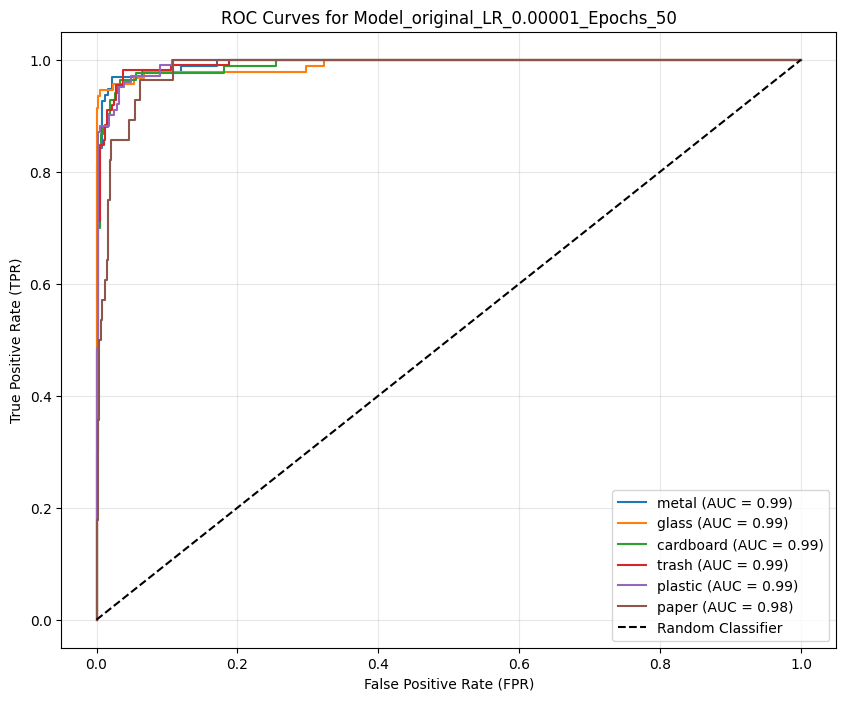

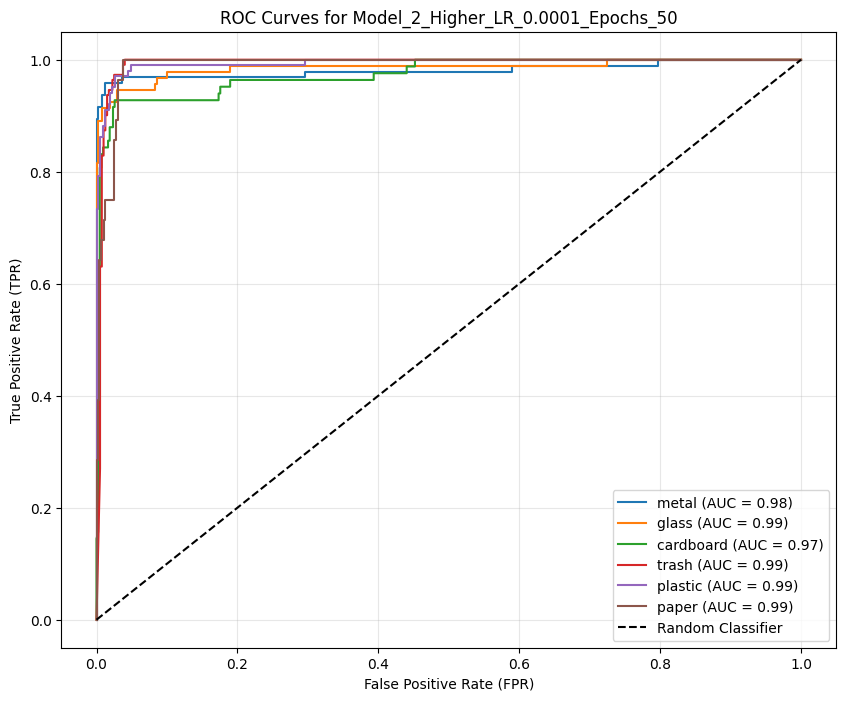

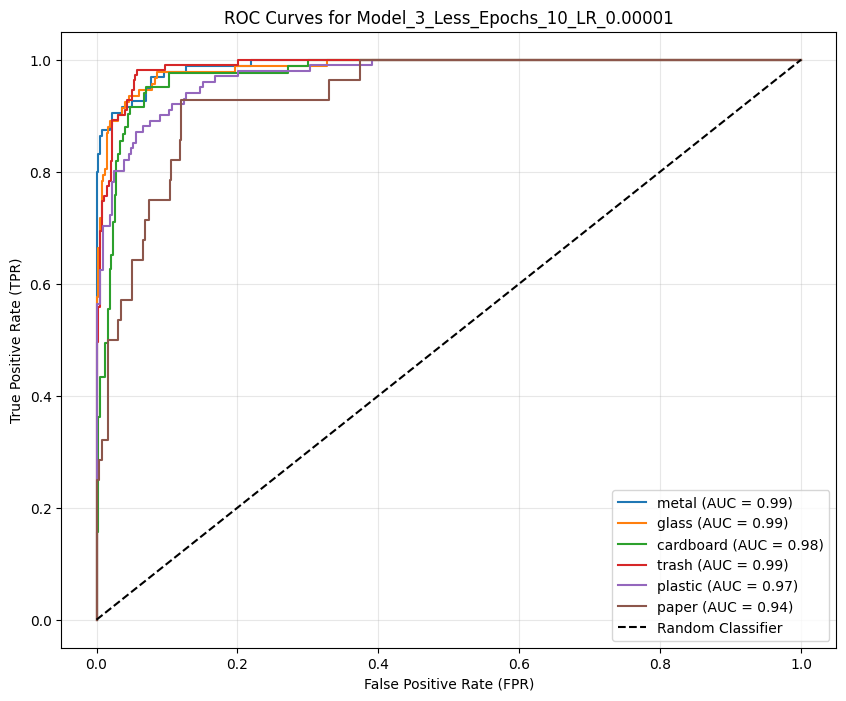

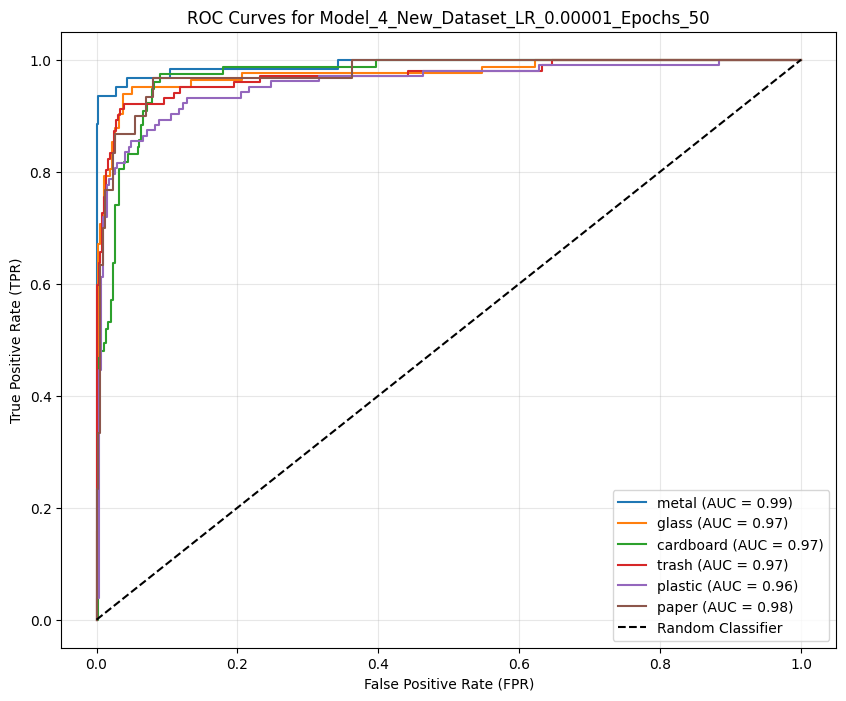

In [ ]:
import matplotlib.pyplot as plt

print("Plotting ROC curves for all models")

# Loop through each model in all_roc_data
for model_name, roc_data in all_roc_data.items():
    plt.figure(figsize=(10, 8))
    plt.title(f"ROC Curves for {model_name}")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")

    # Plot ROC for each class
    for class_name, data in roc_data.items():
        fpr = data["fpr"]
        tpr = data["tpr"]
        auc_score = data["auc"]

        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

    # Plot diagonal random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


# Top Misclassified Classes

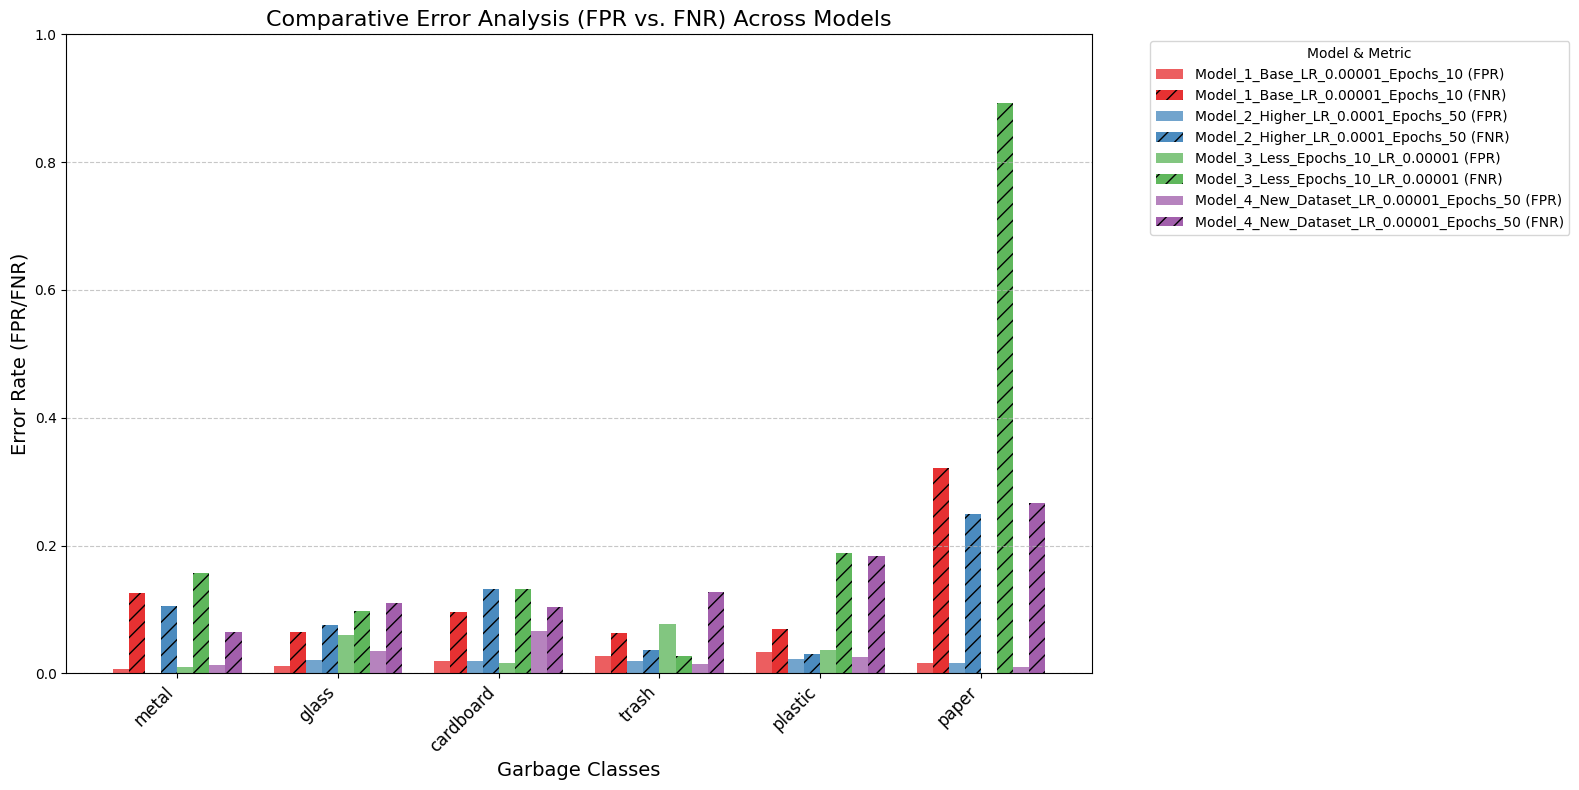

Comparative Error Analysis (FPR vs. FNR) bar chart generated.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_error_rates(cm):
    """
    Calculates False Positive Rate (FPR) and False Negative Rate (FNR)
    for each class from a Confusion Matrix (CM).
    """
    num_classes = cm.shape[0]
    rates = {}

    for i in range(num_classes):
        # True Positives (TP): Diagonal element for the class
        TP = cm[i, i]
        # False Positives (FP): Sum of the i-th column excluding TP
        FP = cm[:, i].sum() - TP
        # False Negatives (FN): Sum of the i-th row excluding TP
        FN = cm[i, :].sum() - TP
        # True Negatives (TN): Sum of all elements excluding the i-th row and column
        TN = cm.sum() - (TP + FP + FN)

        # False Positive Rate (FPR) = FP / (FP + TN)
        # If the denominator is 0, set rate to 0 to avoid division by zero
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0

        # False Negative Rate (FNR) = FN / (FN + TP)
        FNR = FN / (FN + TP) if (FN + TP) > 0 else 0.0

        rates[garbage_classes[i]] = {'FPR': FPR, 'FNR': FNR}

    return rates

# 1. Calculate Error Rates for all models
all_error_rates = {}
for model_name, results in model_eval_results.items():
    cm = results['cm']
    all_error_rates[model_name] = calculate_error_rates(cm)

# 2. Prepare Data for Plotting
# Create a dictionary to hold the rates for each class, across all models
plot_data = {}
for class_name in garbage_classes:
    plot_data[class_name] = {}
    for model_name in all_error_rates:
        plot_data[class_name][model_name + ' - FPR'] = all_error_rates[model_name][class_name]['FPR']
        plot_data[class_name][model_name + ' - FNR'] = all_error_rates[model_name][class_name]['FNR']

# Convert to DataFrame for easier plotting
error_df = pd.DataFrame(plot_data).T # Transpose to have classes as index

# 3. Plotting the Error Rates
fig, ax = plt.subplots(figsize=(16, 8))

num_classes = len(garbage_classes)
num_models = len(model_eval_results)
# We have 2 metrics (FPR, FNR) for each of the 4 models, so 8 bars per class group
bar_width = 0.1
index = np.arange(num_classes)

# Define colors for FPR and FNR for better visual grouping
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3'] # Colors for the 4 models

# Plot bars for each model's FPR and FNR
for i, model_name in enumerate(model_eval_results.keys()):
    # Plot FPR bars
    fpr_data = error_df[model_name + ' - FPR']
    ax.bar(index + (2 * i) * bar_width, fpr_data, bar_width, label=f'{model_name} (FPR)', color=colors[i], alpha=0.7)

    # Plot FNR bars
    fnr_data = error_df[model_name + ' - FNR']
    ax.bar(index + (2 * i + 1) * bar_width, fnr_data, bar_width, label=f'{model_name} (FNR)', color=colors[i], hatch='//', alpha=0.9)


ax.set_xlabel('Garbage Classes', fontsize=14)
ax.set_ylabel('Error Rate (FPR/FNR)', fontsize=14)
ax.set_title('Comparative Error Analysis (FPR vs. FNR) Across Models', fontsize=16)
ax.set_xticks(index + (2 * num_models - 1) * bar_width / 2)
ax.set_xticklabels(garbage_classes, rotation=45, ha='right', fontsize=12)
ax.legend(title='Model & Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.0) # Error rates are between 0 and 1
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Comparative Error Analysis (FPR vs. FNR) bar chart generated.")


# **save models**

In [ ]:

import torch
from google.colab import files

# Dictionary to hold the actual model objects
# Assuming these model objects are still in scope from cell 68d74d51
models_to_save = {
    "Model_original_LR_0.00001_Epochs_10": model_1,
    "Model_2_Higher_LR_0.0001_Epochs_50": model_2,
    "Model_3_Less_Epochs_10_LR_0.00001": model_3,
    "Model_4_New_Dataset_LR_0.00001_Epochs_50": model_4
}

print("Saving models...")
for model_name, model_obj in models_to_save.items():
    filename = f"{model_name.replace(' ', '_')}.pth"
    torch.save(model_obj.state_dict(), filename)
    print(f"Saved {filename}")

print("Models saved. Initiating downloads...")
for model_name in models_to_save.keys():
    filename = f"{model_name.replace(' ', '_')}.pth"
    try:
        files.download(filename)
        print(f"Download initiated for {filename}")
    except Exception as e:
        print(f"Could not initiate download for {filename}: {e}")

print("All available models have been processed for saving and download.")

Saving models...
Saved Model_original_LR_0.00001_Epochs_10.pth
Saved Model_2_Higher_LR_0.0001_Epochs_50.pth
Saved Model_3_Less_Epochs_10_LR_0.00001.pth
Saved Model_4_New_Dataset_LR_0.00001_Epochs_50.pth
Models saved. Initiating downloads...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for Model_original_LR_0.00001_Epochs_10.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for Model_2_Higher_LR_0.0001_Epochs_50.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for Model_3_Less_Epochs_10_LR_0.00001.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for Model_4_New_Dataset_LR_0.00001_Epochs_50.pth
All available models have been processed for saving and download.


Based on the comprehensive analysis of all trained models, here are the key insights:

Impact of Hyperparameters - Epochs and Learning Rate:

Epochs are Critical: Model_3_Less_Epochs_10_LR_0.00001 significantly underperformed with a final validation accuracy of 83.06% and very poor F1-scores for several classes, especially 'paper'. This starkly contrasts with models trained for 50 epochs (e.g., Model_1 at 90.35%), demonstrating that sufficient training epochs are crucial to prevent underfitting and achieve robust performance.
Learning Rate Optimization: A slightly higher learning rate in Model_2_Higher_LR_0001_Epochs_50 resulted in the highest validation accuracy among the models trained on the original dataset (90.77%). This suggests that fine-tuning the learning rate can lead to marginal but meaningful improvements in convergence and overall performance.
Dataset Influence:

Model_4_New_Dataset_LR_0.00001_Epochs_50, trained on the New_Dataset, achieved a final validation accuracy of 87.89%. This was lower than Model_1 (90.35%), which used similar hyperparameters but was trained on the original dataset. This indicates that the New_Dataset might present different characteristics, increased complexity, or perhaps a higher degree of class imbalance or noise, requiring further investigation or specific model adjustments.
Consistent Challenge: The 'Paper' Class:

Across all evaluation metrics (F1-score, Precision, Recall, AUC, and False Negative Rate/False Positive Rate analysis), the paper class consistently proved to be the most challenging for all models. It frequently exhibited the lowest F1-scores and AUC values, along with higher False Negative Rates, indicating that models often struggle to correctly identify and distinguish 'paper' from other waste types.
Strong Performance on Other Core Classes:

Models, particularly Model_1, Model_2, and Model_4, showed strong performance in classifying metal, glass, trash, and plastic waste. These classes generally achieved high precision, recall, and F1-scores, as well as high AUC values (often exceeding 0.90), signifying good discriminative power.
Best Performing Model (on original dataset):

Considering both overall validation accuracy and per-class metrics, Model_2_Higher_LR_0.0001_Epochs_50 emerged as the best performer among the models trained on the original dataset. It achieved the highest validation accuracy and demonstrated improved handling of the challenging 'paper' class compared to Model_1.